## SARIMA

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
new_merged_data = pd.read_csv("new_merged_data.csv")

# Convert 'date' column to datetime format
new_merged_data['date'] = pd.to_datetime(new_merged_data['date'])

# Set 'date' as the index
new_merged_data.set_index('date', inplace=True)

# Display dataset structure
print(new_merged_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2003-01-01 to 2023-09-01
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dom_pax             247 non-null    float64
 1   int_pax             247 non-null    float64
 2   pax                 247 non-null    float64
 3   dom_flt             247 non-null    float64
 4   int_flt             247 non-null    float64
 5   flt                 247 non-null    float64
 6   dom_rpm             247 non-null    float64
 7   int_rpm             247 non-null    float64
 8   rpm                 247 non-null    float64
 9   dom_asm             247 non-null    float64
 10  int_asm             247 non-null    float64
 11  asm                 247 non-null    float64
 12  dom_lf              247 non-null    float64
 13  int_lf              247 non-null    float64
 14  lf                  247 non-null    float64
 15  fuel_spot_price     247 non-null    fl

In [436]:
# Define training period (2003-2019 Pre-COVID)
train_end = "2019-12-01"
test_start = "2023-04-01"
test_end = "2023-09-01"

# Train/Test split for each target variable
train_data = new_merged_data.loc[:train_end]
test_data = new_merged_data.loc[test_start:test_end]

In [437]:
# Function to perform Augmented Dickey-Fuller (ADF) test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Test for {series.name}:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("✅ The series is stationary (Reject H0)")
    else:
        print("❌ The series is NOT stationary (Fail to Reject H0)")

# Run ADF test for all target variables
targets = ["pax", "flt", "lf", "rpm"]
for target in targets:
    adf_test(train_data[target])

ADF Test for pax:
Test Statistic: 0.2780325633033331
P-Value: 0.9763138792113946
Critical Values: {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}
❌ The series is NOT stationary (Fail to Reject H0)
ADF Test for flt:
Test Statistic: -1.9028568116189404
P-Value: 0.3307183721799789
Critical Values: {'1%': -3.4652439354133255, '5%': -2.8768752281673717, '10%': -2.574944653739612}
❌ The series is NOT stationary (Fail to Reject H0)
ADF Test for lf:
Test Statistic: -2.0003118197013157
P-Value: 0.28643639383468544
Critical Values: {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}
❌ The series is NOT stationary (Fail to Reject H0)
ADF Test for rpm:
Test Statistic: -0.146546617051699
P-Value: 0.9446003908862262
Critical Values: {'1%': -3.4652439354133255, '5%': -2.8768752281673717, '10%': -2.574944653739612}
❌ The series is NOT stationary (Fail to Reject H0)


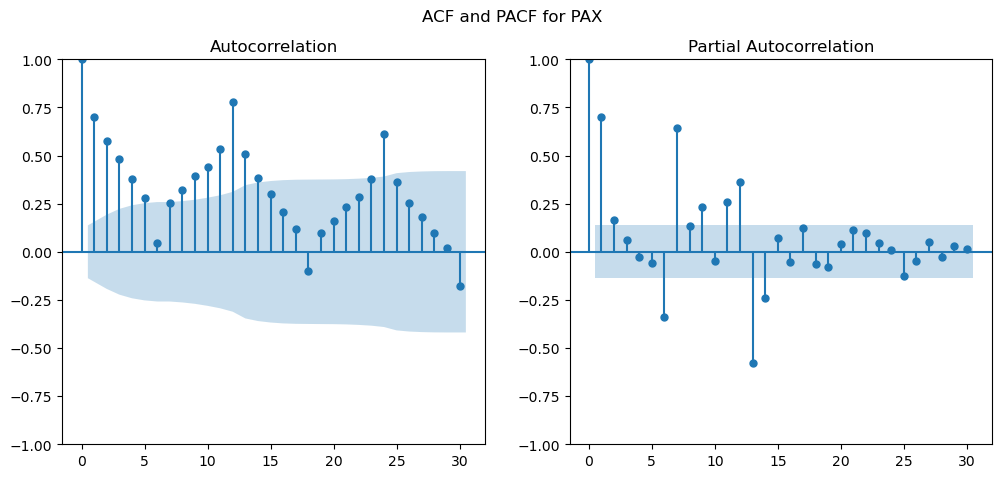

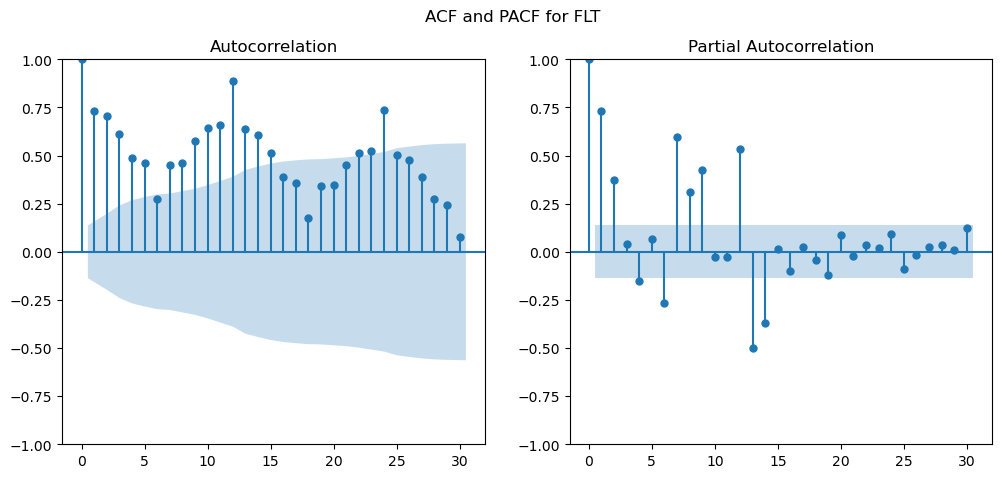

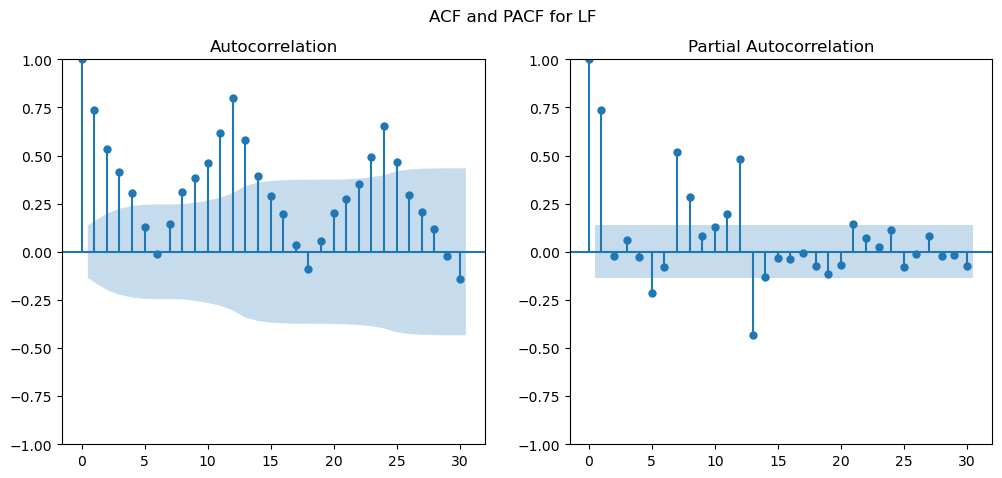

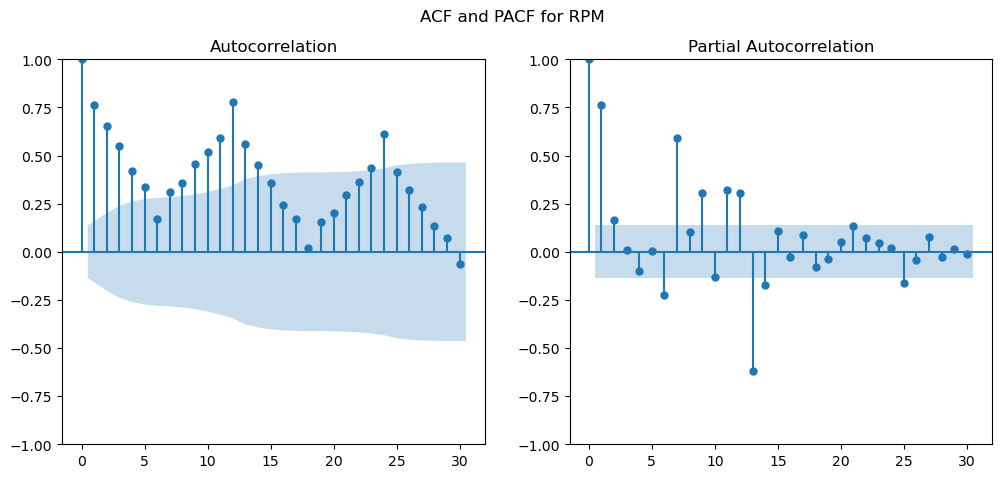

In [438]:
# Function to plot ACF and PACF
def plot_acf_pacf(target):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sm.graphics.tsa.plot_acf(train_data[target], lags=30, ax=axes[0])
    sm.graphics.tsa.plot_pacf(train_data[target], lags=30, ax=axes[1])
    plt.suptitle(f"ACF and PACF for {target.upper()}")
    plt.show()

# Generate ACF/PACF plots for all target variables
for target in targets:
    plot_acf_pacf(target)

In [439]:
# Function to find optimal SARIMA parameters using auto_arima
# Set a random seed for reproducibility
import numpy as np
import pmdarima as pm

np.random.seed(42)

# Function to find optimal SARIMA parameters using auto_arima
def find_best_sarima_params(target):
    print(f"\nFinding best SARIMA parameters for {target.upper()}...")
    
    # Set random_state to ensure consistent results
    auto_model = pm.auto_arima(
        train_data[target], 
        seasonal=True, 
        m=12, 
        stepwise=True, 
        suppress_warnings=True,
        random_state=42  # Ensures stability in AIC selection
    )
    
    print(auto_model.summary())
    return auto_model.order, auto_model.seasonal_order

# Store the best parameters
sarima_params = {}

for target in targets:
    sarima_params[target] = find_best_sarima_params(target)


Finding best SARIMA parameters for PAX...
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 718.368
Date:                              Mon, 10 Mar 2025   AIC                          -1422.736
Time:                                      12:33:22   BIC                          -1399.934
Sample:                                  01-01-2003   HQIC                         -1413.501
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      2.466      0.014 

In [440]:
sarima_params

{'pax': ((2, 0, 0), (2, 1, 1, 12)),
 'flt': ((2, 0, 0), (2, 1, 2, 12)),
 'lf': ((1, 1, 1), (1, 0, 2, 12)),
 'rpm': ((2, 0, 1), (0, 1, 1, 12))}

In [441]:
# Function to train SARIMA model with optimized parameters
def train_sarima(series, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(series, 
                                      order=order, 
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False).fit()
    return model

# Train SARIMA models for four target variables using optimized parameters
sarima_models = {}

for target in targets:
    print(f"Training SARIMA for {target} with parameters {sarima_params[target]}...")
    order, seasonal_order = sarima_params[target]
    sarima_models[target] = train_sarima(train_data[target], order, seasonal_order)

Training SARIMA for pax with parameters ((2, 0, 0), (2, 1, 1, 12))...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92127D+00    |proj g|=  1.03611D+01


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.92276D+00    |proj g|=  2.71037D+00

At iterate   10    f= -2.94208D+00    |proj g|=  4.20635D+01

At iterate   15    f= -3.00035D+00    |proj g|=  4.74722D-01

At iterate   20    f= -3.00283D+00    |proj g|=  1.13514D+01

At iterate   25    f= -3.04945D+00    |proj g|=  3.50625D+01

At iterate   30    f= -3.07723D+00    |proj g|=  2.52038D-01

At iterate   35    f= -3.07728D+00    |proj g|=  1.07004D+00

At iterate   40    f= -3.08082D+00    |proj g|=  2.94801D+00

At iterate   45    f= -3.08168D+00    |proj g|=  2.15987D-02

At iterate   50    f= -3.08194D+00    |proj g|=  1.19843D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Training SARIMA for flt with parameters ((2, 0, 0), (2, 1, 2, 12))...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.52818D+00    |proj g|=  1.08568D+01

At iterate    5    f= -2.53528D+00    |proj g|=  4.43331D+00

At iterate   10    f= -2.58966D+00    |proj g|=  1.64967D+01

At iterate   15    f= -2.60604D+00    |proj g|=  2.88344D+00

At iterate   20    f= -2.63354D+00    |proj g|=  1.15347D+00

At iterate   25    f= -2.63409D+00    |proj g|=  3.70999D-01

At iterate   30    f= -2.63996D+00    |proj g|=  6.51897D+00

At iterate   35    f= -2.64232D+00    |proj g|=  6.15140D-02

At iterate   40    f= -2.64311D+00    |proj g|=  1.79806D+00

At iterate   45    f= -2.64698D+00    |proj g|=  6.90314D-01


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -2.64767D+00    |proj g|=  2.38540D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   2.385D-01  -2.648D+00
  F =  -2.6476712475171036     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Training SARIMA for lf with parameters ((1, 1, 1), (1, 0, 2, 12))...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89632D+00    |proj g|=  1.78802D+01

At iterate    5    f= -2.33593D+00    |proj g|=  8.41200D+00



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f= -3.28719D+00    |proj g|=  1.02767D+01

At iterate   25    f= -3.33433D+00    |proj g|=  3.34316D+01

At iterate   30    f= -3.35048D+00    |proj g|=  9.58308D-01

At iterate   35    f= -3.35099D+00    |proj g|=  7.96536D-02

At iterate   40    f= -3.35817D+00    |proj g|=  7.85939D+00

At iterate   45    f= -3.35931D+00    |proj g|=  5.16760D-01

At iterate   50    f= -3.35934D+00    |proj g|=  9.39549D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     75      1     0     0   9.395D-01  -3.359D+00
  F =  -3.3593434121005443     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [511]:
# Forecast test period
forecast_results = {}
evaluation_results = {}

for target in targets:
    f_steps = len(test_data)  # Number of test period steps
    forecast_results[target] = sarima_models[target].forecast(steps=f_steps)

    # Compute evaluation metrics
    y_true = test_data[target]
    y_pred = forecast_results[target]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Store results
    evaluation_results[target] = {"MAE": mae, "RMSE": rmse}

# Convert evaluation results to DataFrame
eval_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
print(eval_df)

          MAE      RMSE
pax  0.026622  0.032869
flt  0.060952  0.067358
lf   0.046781  0.049711
rpm  0.031071  0.036491


In [517]:
def compute_aicc(aic, k, n):
    """
    Compute AICc (Corrected AIC) from AIC.
    
    Parameters:
    - aic: AIC value from SARIMA model
    - k: Number of estimated parameters in the model
    - n: Number of observations (sample size)
    
    Returns:
    - AICc value
    """
    if n - k - 1 == 0:  # Avoid division by zero
        return float("inf")
    
    return aic + (2 * k * (k + 1)) / (n - k - 1)

# Example: Compute AICc for each SARIMA model
n = 204  # Total observations

sarima_results = {
    "pax": {"AIC": -1422.736, "K": 6},  # K includes p, d, q, P, D, Q, and intercept
    "flt": {"AIC": -1209.092, "K": 7},
    "lf": {"AIC": -1079.848, "K": 6},
    "rpm": {"AIC": -1443.420, "K": 6},
}

# Compute AICc for each variable
for target, values in sarima_results.items():
    aicc = compute_aicc(values["AIC"], values["K"], n)
    print(f"{target.upper()} - AICc: {aicc:.3f}")

PAX - AICc: -1422.310
FLT - AICc: -1208.521
LF - AICc: -1079.422
RPM - AICc: -1442.994


In [519]:
manual_aic_values = {
    "pax": -1422.310,
    "flt": -1208.521,
    "lf": -1079.422,
    "rpm": -1442.994
}

# Initialize dictionary to store results
sarima_results = {}

for target in targets:
    # Extract SARIMA model parameters
    order, seasonal_order = sarima_params[target]

    # Store manually recorded AIC instead of best_model.aic
    aic = manual_aic_values[target]
    
    # Store model details
    sarima_results[target] = {
        "Model": f"SARIMA{order}x{seasonal_order}",  # Model name with hyperparameters
        "AICc": aic,
        "MAE": eval_df.loc[target, "MAE"],
        "RMSE": eval_df.loc[target, "RMSE"]
    }

# Convert results to DataFrame
sarima_summary_df = pd.DataFrame.from_dict(sarima_results, orient='index')

# Print results
print("\nSARIMA Model Summary (Hyperparameters, AIC, MAE, RMSE):")
print(sarima_summary_df)


SARIMA Model Summary (Hyperparameters, AIC, MAE, RMSE):
                             Model      AICc       MAE      RMSE
pax  SARIMA(2, 0, 0)x(2, 1, 1, 12) -1422.310  0.026622  0.032869
flt  SARIMA(2, 0, 0)x(2, 1, 2, 12) -1208.521  0.060952  0.067358
lf   SARIMA(1, 1, 1)x(1, 0, 2, 12) -1079.422  0.046781  0.049711
rpm  SARIMA(2, 0, 1)x(0, 1, 1, 12) -1442.994  0.031071  0.036491


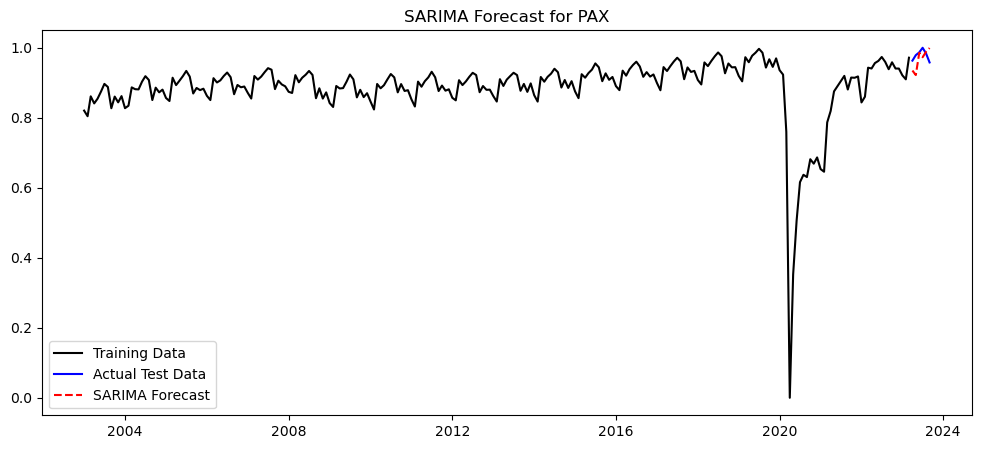

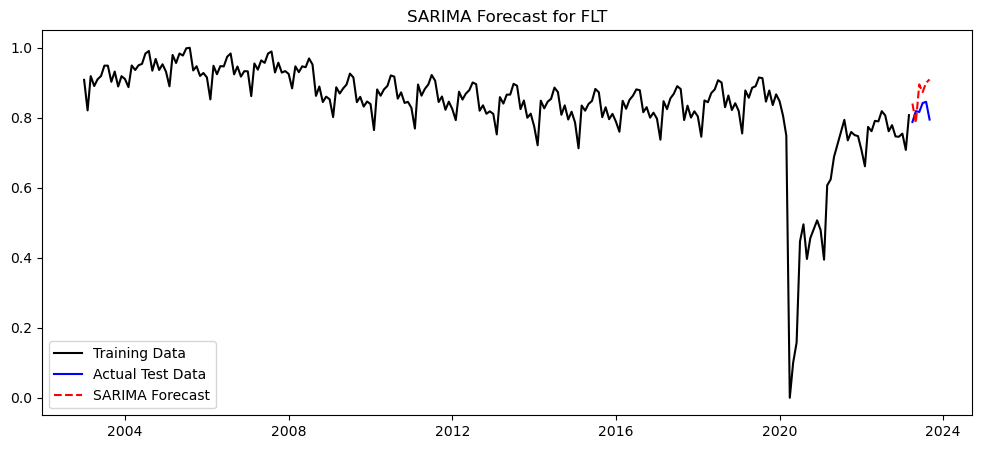

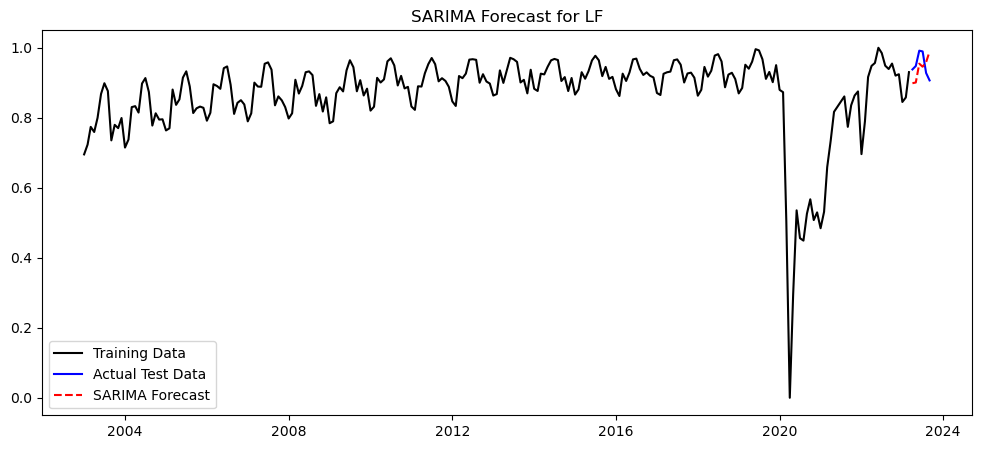

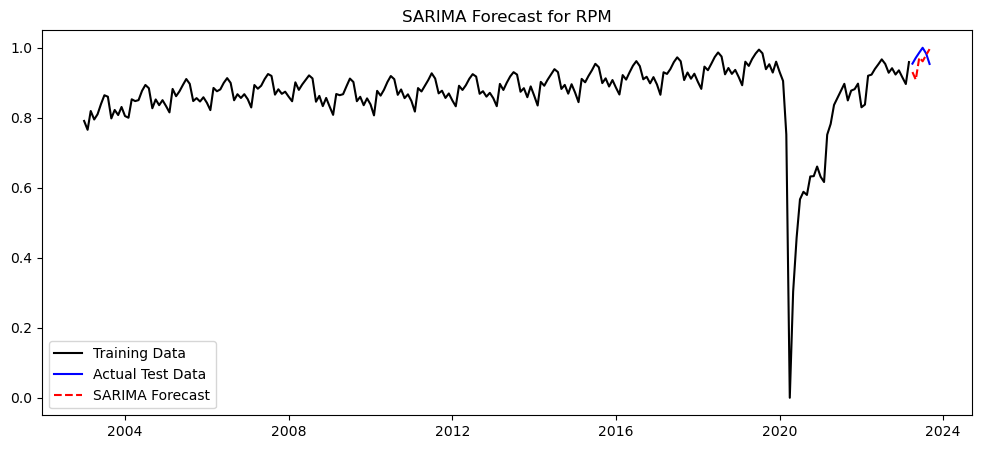

In [507]:
# Function to plot SARIMA forecast vs. actual
def plot_sarima_forecast(target):
    plt.figure(figsize=(12, 5))
    plt.plot(train_data.index, train_data[target], label="Training Data", color="black")
    plt.plot(test_data.index, test_data[target], label="Actual Test Data", color="blue")
    plt.plot(test_data.index, forecast_results[target], label="SARIMA Forecast", color="red", linestyle="dashed")
    plt.legend()
    plt.title(f"SARIMA Forecast for {target.upper()}")
    plt.show()

# Generate and display plots
for target in targets:
    plot_sarima_forecast(target)

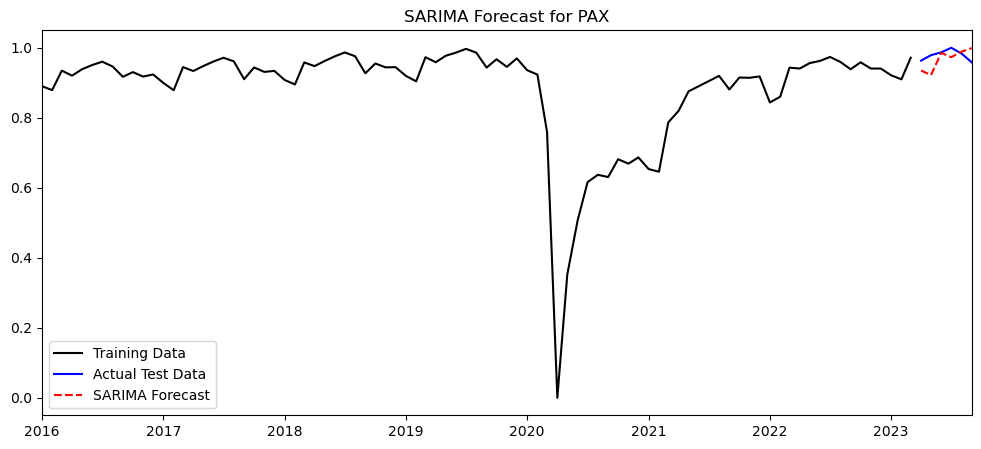

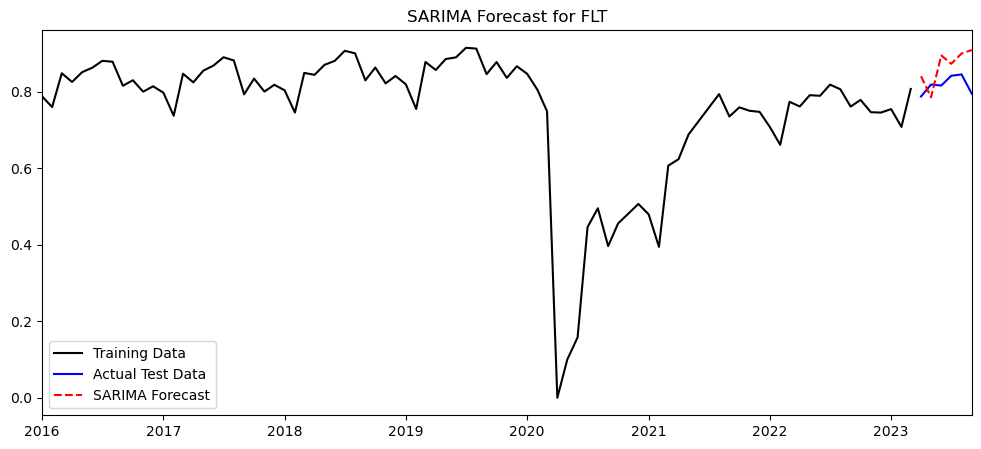

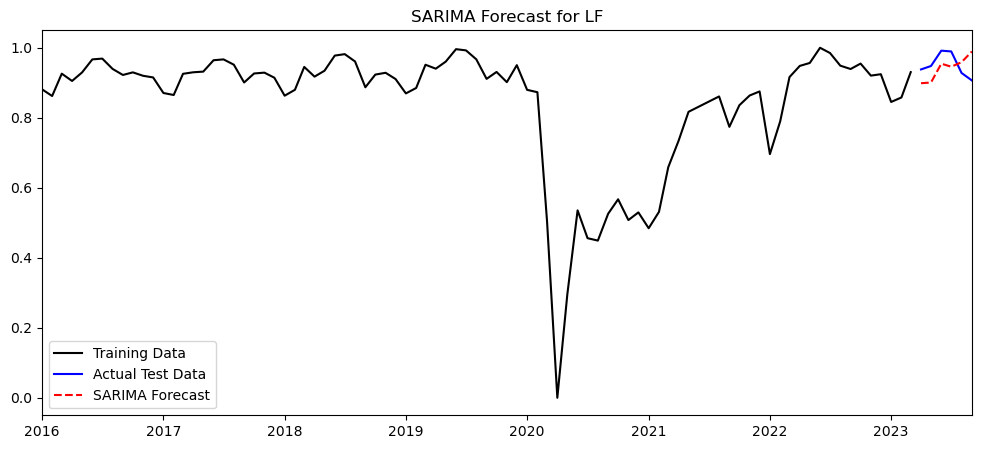

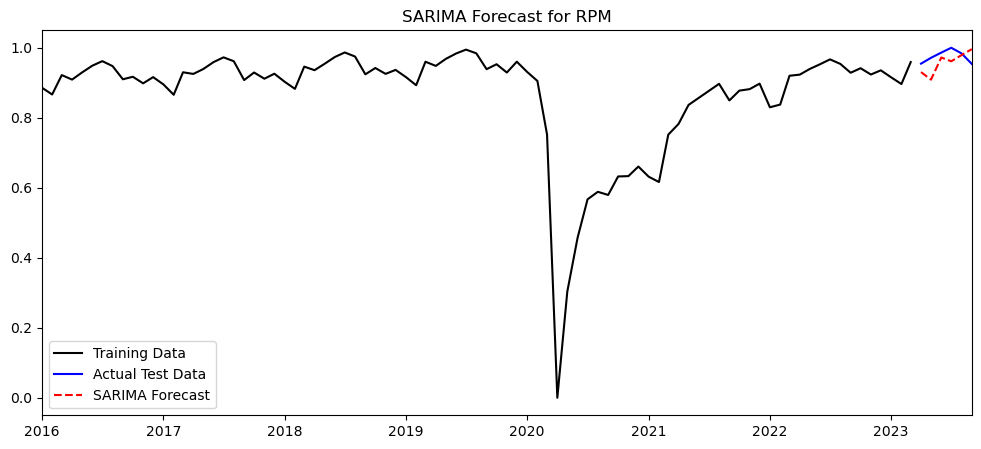

In [515]:
# Convert forecast_results to a DataFrame (if it's a dictionary of series)
forecast_df = pd.DataFrame(forecast_results)

# Function to plot SARIMA forecast vs. actual (showing only 2012 onwards)
def plot_sarima_forecast(target):
    plt.figure(figsize=(12, 5))
    
    # Define start date for filtering
    start_date = "2016-01-01"
    
    # Plot training data (filtered)
    plt.plot(train_data.loc[start_date:].index, train_data.loc[start_date:, target], 
             label="Training Data", color="black")
    
    # Plot test data (filtered)
    plt.plot(test_data.loc[start_date:].index, test_data.loc[start_date:, target], 
             label="Actual Test Data", color="blue")
    
    # Ensure forecast_df has proper datetime index before filtering
    if isinstance(forecast_df.index, pd.DatetimeIndex):
        plt.plot(test_data.loc[start_date:].index, forecast_df.loc[start_date:, target], 
                 label="SARIMA Forecast", color="red", linestyle="dashed")
    else:
        print(f"Warning: Forecast index is not a DatetimeIndex for {target}")

    plt.legend()
    plt.title(f"SARIMA Forecast for {target.upper()}")
    plt.xlim(pd.to_datetime(start_date), test_data.index[-1])  # Set x-axis limits
    plt.show()

# Generate and display plots
for target in targets:
    plot_sarima_forecast(target)

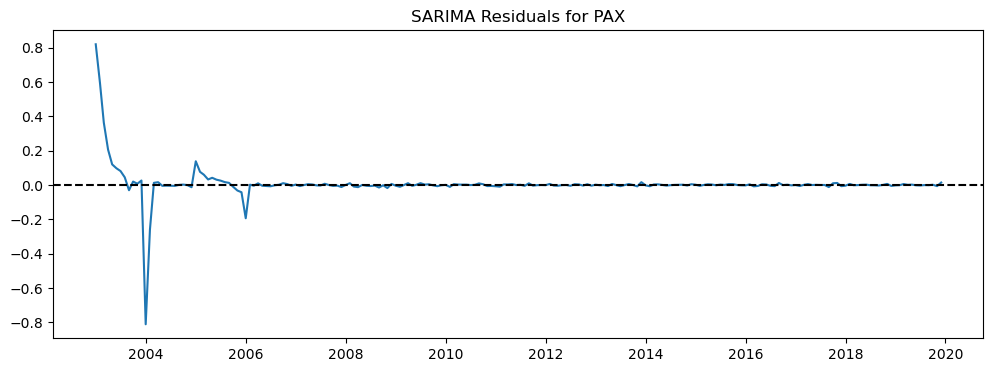

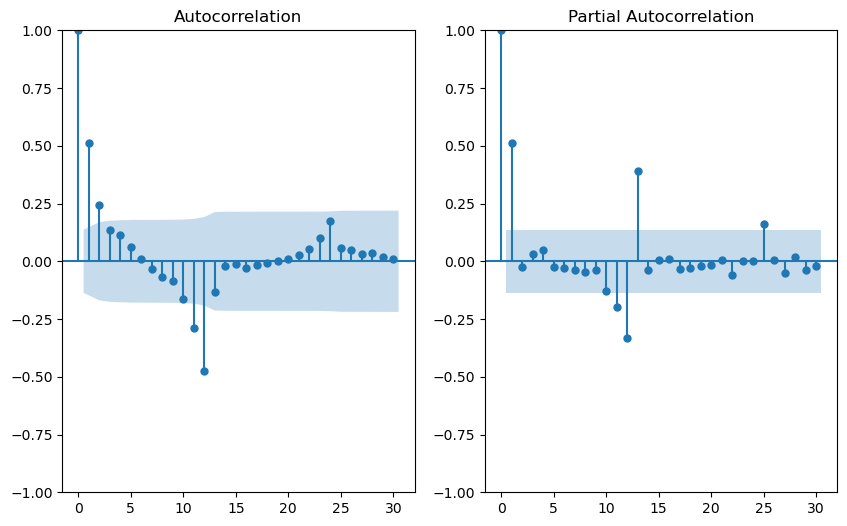

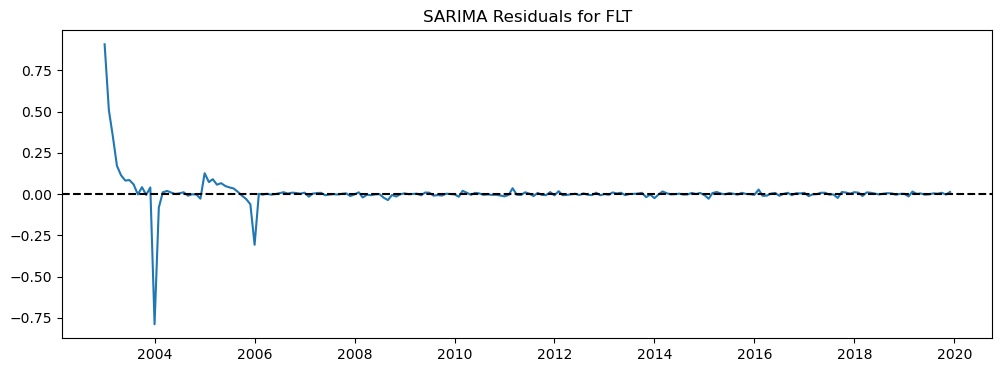

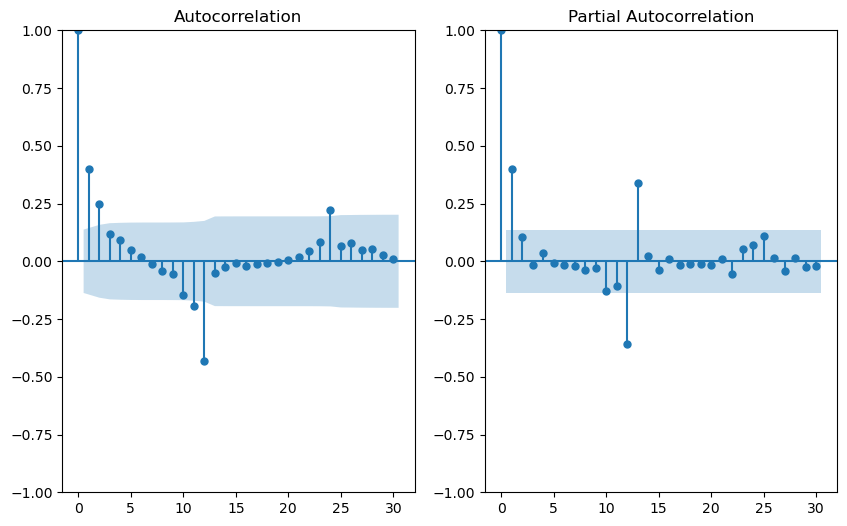

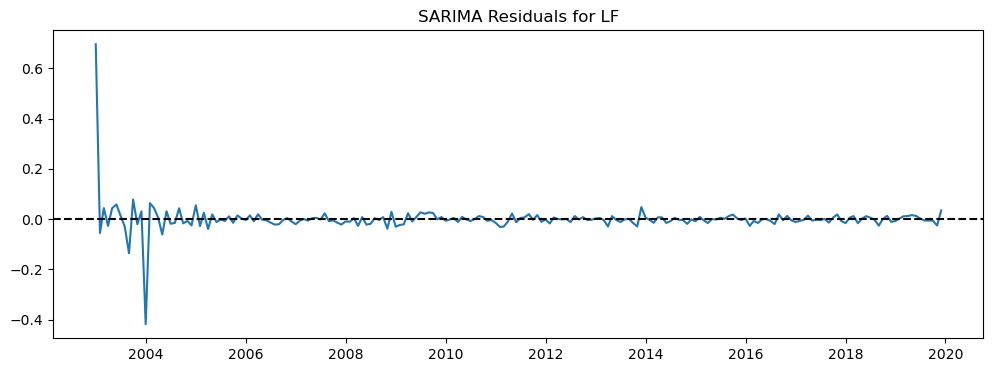

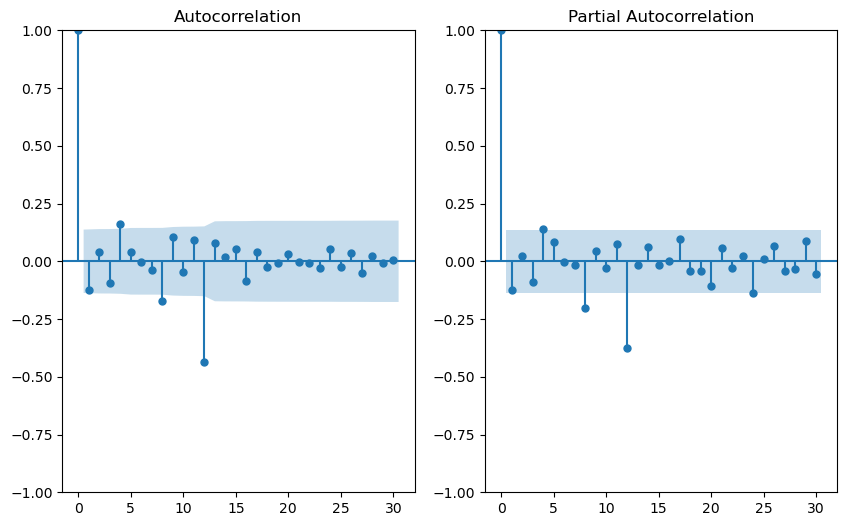

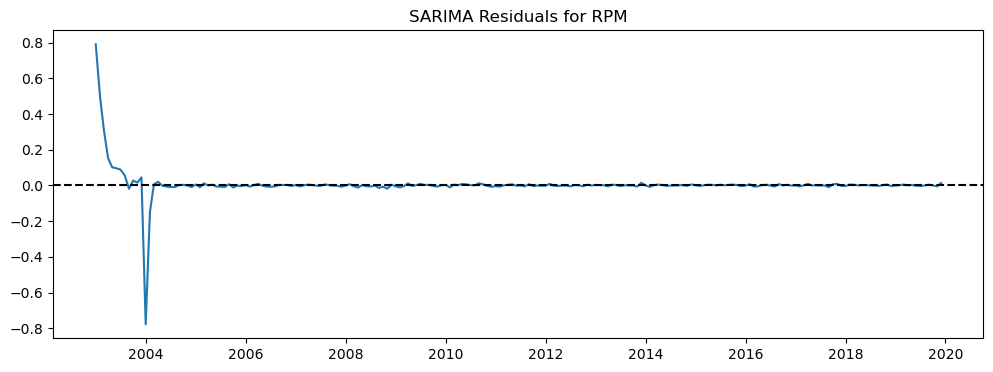

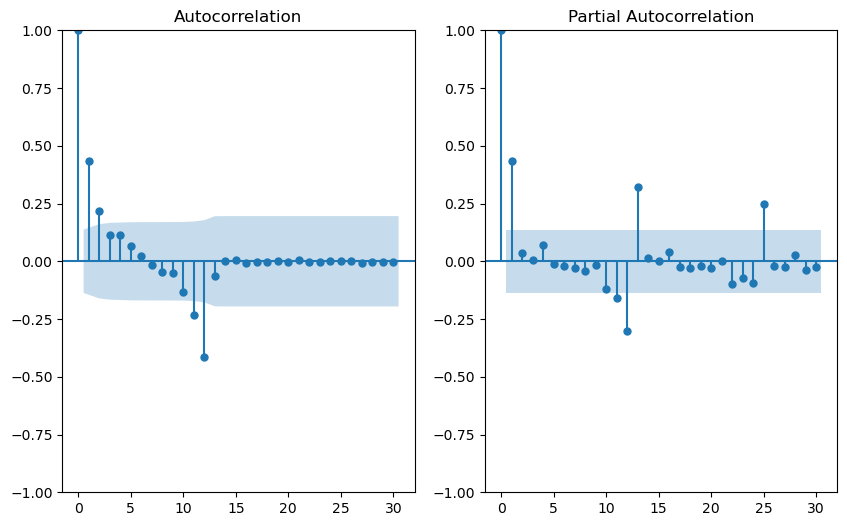

In [459]:
# Function to analyze residuals
def plot_residual_analysis(target):
    residuals = sarima_models[target].resid

    # Residual Plot
    plt.figure(figsize=(12, 4))
    plt.plot(residuals)
    plt.axhline(y=0, linestyle='--', color='black')
    plt.title(f"SARIMA Residuals for {target.upper()}")
    plt.show()

    # ACF and PACF of Residuals
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[0])
    sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=axes[1])
    plt.show()

# Generate residual analysis for all target variables
for target in targets:
    plot_residual_analysis(target)

In [461]:
# Define forecast range based on the model's index
future_start = train_data.index[-1]  # Last date in training data
future_end = future_dates[-1]  # Last date in forecast period

# Ensure future_dates aligns with prediction index
future_forecasts = {}

for target in targets:
    future_forecasts[target] = sarima_models[target].predict(start=future_start, end=future_end)

# Convert future forecasts to DataFrame
future_forecasts_df = pd.DataFrame(future_forecasts, index=future_dates)
future_forecasts_df.index.name = "date"

# Display forecasted data
print(future_forecasts_df)

                 pax       flt        lf       rpm
date                                              
2023-10-01  1.001207  0.901043  0.960655  0.977109
2023-11-01  0.983906  0.862050  0.948000  0.955643
2023-12-01  0.995804  0.884530  0.955682  0.976424
2024-01-01  0.966180  0.862032  0.925086  0.950966
2024-02-01  0.951237  0.804163  0.927973  0.927426
2024-03-01  1.015288  0.913657  0.971511  0.990903
2024-04-01  1.002350  0.894956  0.963328  0.979574
2024-05-01  1.017651  0.921518  0.972747  0.996974
2024-06-01  1.028431  0.930095  0.998195  1.013716
2024-07-01  1.039097  0.953256  1.001308  1.025610
2024-08-01  1.027599  0.946968  0.988618  1.013738
2024-09-01  0.983081  0.872907  0.951118  0.965471


In [544]:
# Create a copy of future_forecasts_df with only 'pax' and 'rpm' columns
forecasts_df_sarima = future_forecasts_df[["pax", "rpm"]].copy()

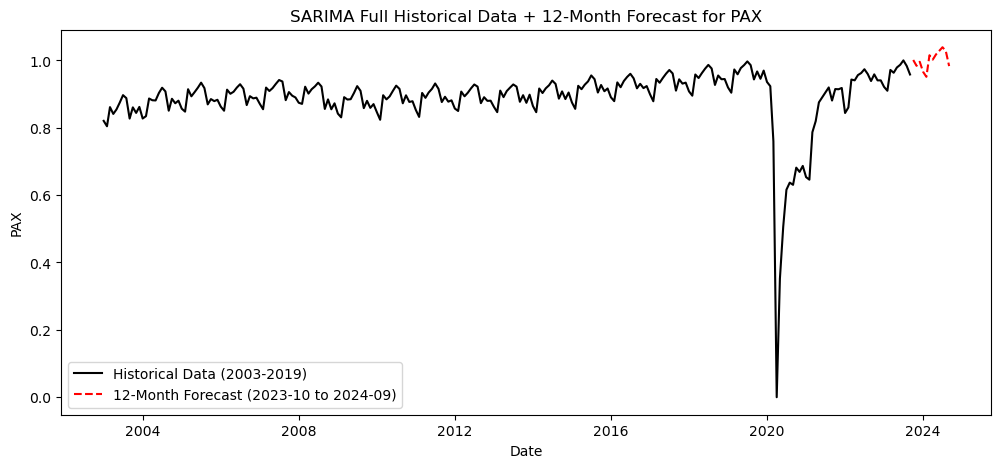

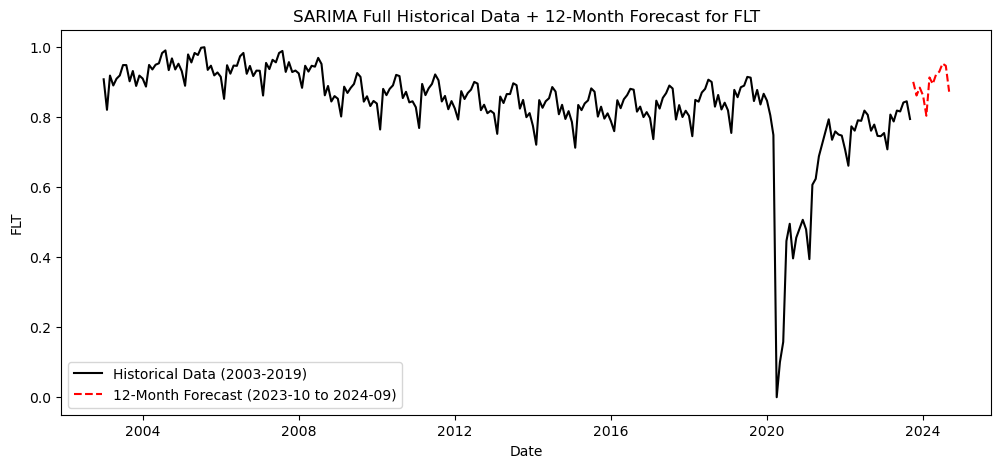

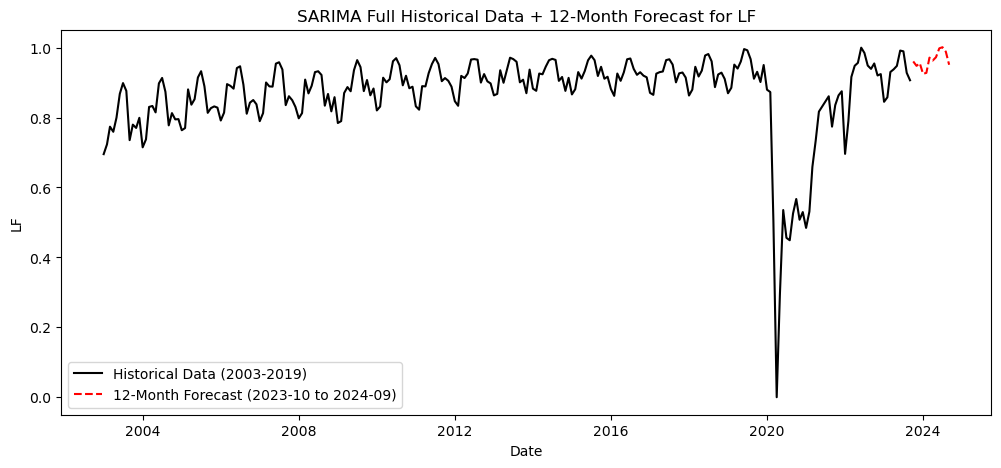

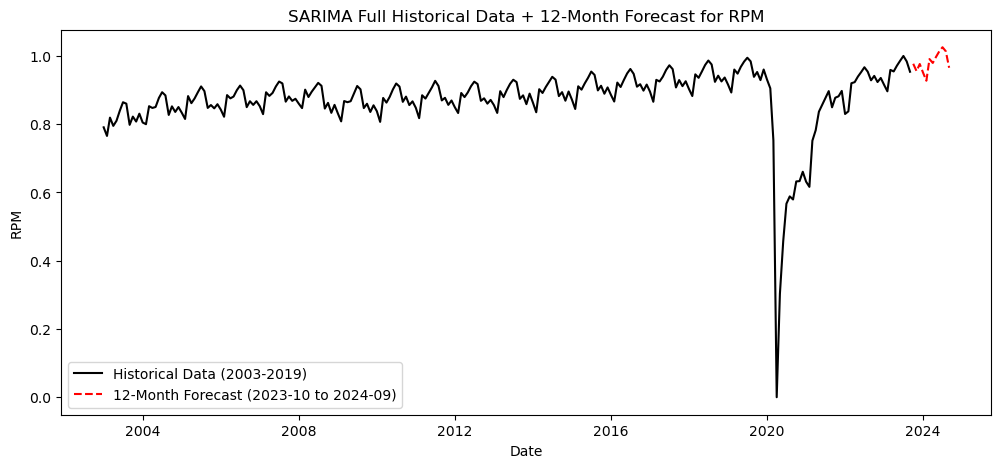

In [463]:
# Function to plot historical data + 12-month forecast
def plot_full_forecast(target):
    plt.figure(figsize=(12, 5))
    
    # Plot full historical data (2003-2019)
    plt.plot(new_merged_data.index, new_merged_data[target], label="Historical Data (2003-2019)", color="black")
    
    # Plot SARIMA forecast for the future 12 months
    plt.plot(future_forecasts_df.index, future_forecasts_df[target], 
             label="12-Month Forecast (2023-10 to 2024-09)", color="red", linestyle="dashed")
    
    plt.legend()
    plt.title(f"SARIMA Full Historical Data + 12-Month Forecast for {target.upper()}")
    plt.xlabel("Date")
    plt.ylabel(target.upper())
    plt.show()

# Generate and display plots for all target variables
for target in targets:
    plot_full_forecast(target)

### Will include Covid period help?

In [465]:
# Update training period: Use all data before the test period (2003 - 2023-03)
train_end = "2023-03-01"
test_start = "2023-04-01"
test_end = "2023-09-01"

# Train/Test split for each target variable
train_data = new_merged_data.loc[:train_end]
test_data = new_merged_data.loc[test_start:test_end]

In [467]:
# Function to find optimal SARIMA parameters using auto_arima
def find_best_sarima_params(target):
    print(f"\nFinding best SARIMA parameters for {target.upper()}...")
    auto_model = auto_arima(train_data[target], seasonal=True, m=12, 
                            stepwise=True, suppress_warnings=True)
    print(auto_model.summary())
    return auto_model.order, auto_model.seasonal_order

# Store the best parameters
sarima_params_all = {}

for target in targets:
    sarima_params_all[target] = find_best_sarima_params(target)


Finding best SARIMA parameters for PAX...
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  241
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 337.980
Date:                              Mon, 10 Mar 2025   AIC                           -667.961
Time:                                      14:23:43   BIC                           -654.022
Sample:                                           0   HQIC                          -662.345
                                              - 241                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2042      0.022      9.213      0.000 

In [468]:
# Function to train SARIMA model with optimized parameters
def train_sarima(series, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(series, 
                                      order=order, 
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False).fit()
    return model

# Train SARIMA models for four target variables using optimized parameters
sarima_models_all = {}

for target in targets:
    print(f"Training SARIMA for {target} with parameters {sarima_params_all[target]}...")
    order, seasonal_order = sarima_params_all[target]
    sarima_models_all[target] = train_sarima(train_data[target], order, seasonal_order)

Training SARIMA for pax with parameters ((1, 0, 0), (0, 0, 1, 12))...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23107D+00    |proj g|=  1.00145D+00

At iterate    5    f= -1.23454D+00    |proj g|=  9.50445D-01

At iterate   10    f= -1.25116D+00    |proj g|=  1.06894D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     31      1     0     0   1.214D-04  -1.251D+00
  F =  -1.2512037040961492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15539D+00    |proj g|=  1.12694D+00


 This problem is unconstrained.



At iterate    5    f= -1.16119D+00    |proj g|=  1.17696D+00

At iterate   10    f= -1.19013D+00    |proj g|=  7.07482D-02

At iterate   15    f= -1.20108D+00    |proj g|=  2.22585D+00

At iterate   20    f= -1.20904D+00    |proj g|=  6.27556D-02

At iterate   25    f= -1.21208D+00    |proj g|=  1.96708D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   7.211D-04  -1.212D+00
  F =  -1.2121038532770527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Training SARIMA for lf with parameters ((1, 0, 0), (1, 0, 0, 12))...
RUNNING THE L-BFGS-B CODE

           * * *


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     39      1     0     0   3.986D-04  -1.271D+00
  F =  -1.2708816458593193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Training SARIMA for rpm with parameters ((1, 0, 0), (0, 0, 1, 12))...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25823D+00    |proj g|=  7.75372D-01

At iterate    5    f= -1.26066D+00    |proj g|=  8.67127D-01

At iterate   10    f= -1.27256D+00    |proj g|=  4.27152D-02


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [469]:
# Forecast test period
forecast_results_all = {}
evaluation_results_all = {}

for target in targets:
    f_steps = len(test_data)  # Number of test period steps
    forecast_results_all[target] = sarima_models_all[target].forecast(steps=f_steps)

    # Compute evaluation metrics
    y_true = test_data[target]
    y_pred = forecast_results_all[target]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    evaluation_results_all[target] = {"MAE": mae, "RMSE": rmse}

# Convert evaluation results to DataFrame
eval_df_all = pd.DataFrame.from_dict(evaluation_results_all, orient='index')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

In [470]:
# Initialize dictionary to store results
sarima_results_all = {}

for target in targets:
    # Extract SARIMA model parameters
    order, seasonal_order = sarima_params_all[target]
    
    # Extract AIC, BIC
    aic = sarima_models_all[target].aic
    bic = sarima_models_all[target].bic
    
    # Store all details
    sarima_results_all[target] = {
        "Model": f"SARIMA{order}x{seasonal_order}",  # Model name with hyperparameters
        "AIC": aic,
        "BIC": bic,
        "MAE": eval_df_all.loc[target, "MAE"],
        "RMSE": eval_df_all.loc[target, "RMSE"]
    }

# Convert results to DataFrame
sarima_summary_df_all = pd.DataFrame.from_dict(sarima_results_all, orient='index')

# Print results
print("\nSARIMA Model Summary (Trained on All Historical Data Until Test Set Start):")
print(sarima_summary_df_all)


SARIMA Model Summary (Trained on All Historical Data Until Test Set Start):
                             Model         AIC         BIC       MAE      RMSE
pax  SARIMA(1, 0, 0)x(0, 0, 1, 12) -597.080185 -586.792148  0.017348  0.020949
flt  SARIMA(1, 1, 0)x(2, 0, 1, 12) -574.234057 -557.380867  0.044317  0.047341
lf   SARIMA(1, 0, 0)x(1, 0, 0, 12) -606.564953 -596.276916  0.021040  0.029021
rpm  SARIMA(1, 0, 0)x(0, 0, 1, 12) -607.374346 -597.086309  0.024060  0.028723


## SARIMAX

In [526]:
# Define training period (2003-2019 Pre-COVID)
train_end = "2019-12-01"
test_start = "2023-04-01"
test_end = "2023-09-01"

# Train/Test split for each target variable
train_data = new_merged_data.loc[:train_end]
test_data = new_merged_data.loc[test_start:test_end]


=== Running SARIMAX for PAX ===
Optimal Order: (2, 0, 0), Seasonal Order: (2, 1, 1, 12)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 0.0314, RMSE: 0.0320


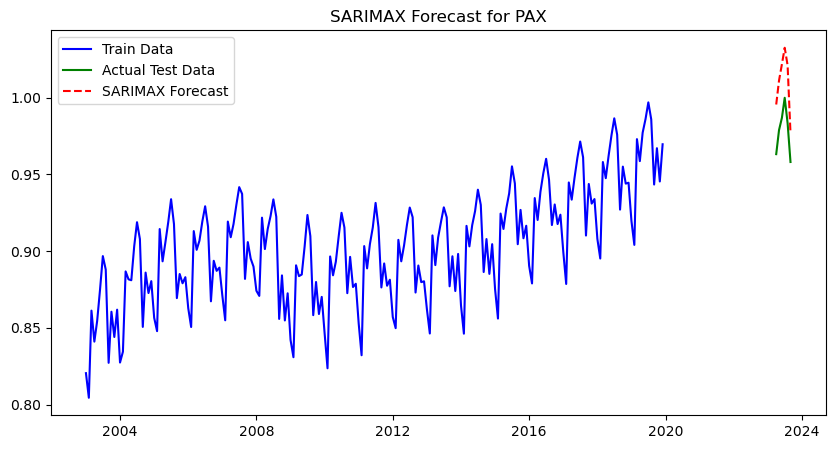


=== Running SARIMAX for FLT ===
Optimal Order: (2, 0, 0), Seasonal Order: (2, 1, 2, 12)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 0.0976, RMSE: 0.0983


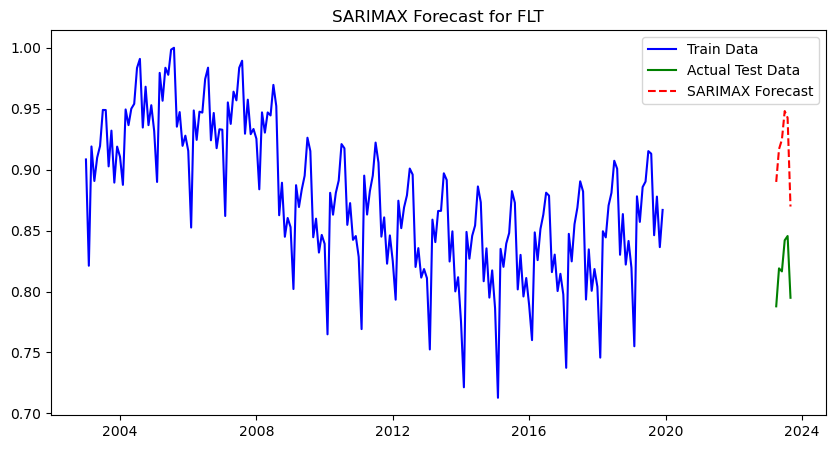


=== Running SARIMAX for LF ===
Optimal Order: (1, 1, 1), Seasonal Order: (1, 0, 2, 12)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE: 0.0251, RMSE: 0.0310


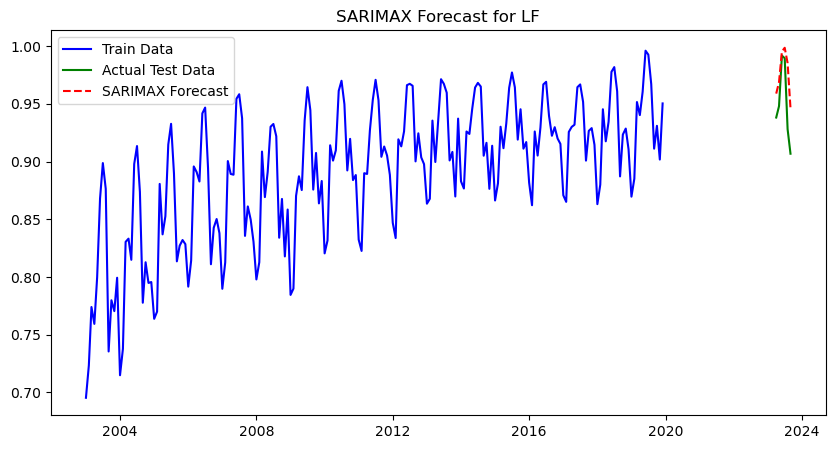


=== Running SARIMAX for RPM ===
Optimal Order: (2, 0, 1), Seasonal Order: (0, 1, 1, 12)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 0.0212, RMSE: 0.0219


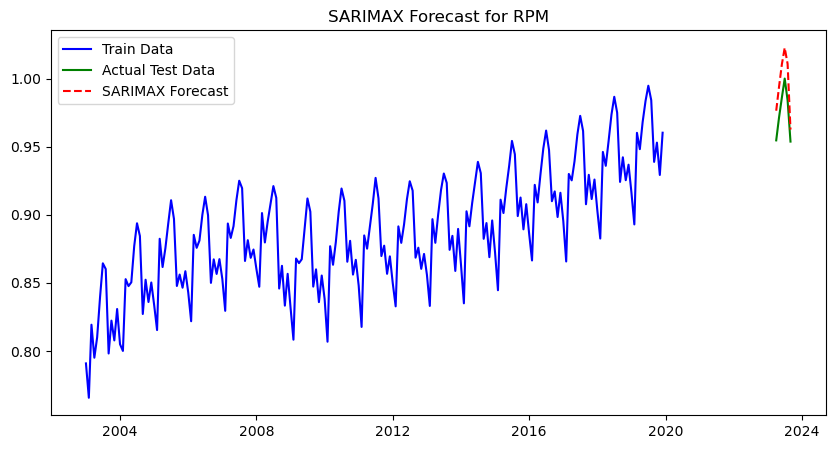


Model Summary for PAX:
                                      SARIMAX Results                                       
Dep. Variable:                                  pax   No. Observations:                  204
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 628.715
Date:                              Tue, 11 Mar 2025   AIC                          -1245.430
Time:                                      11:57:32   BIC                          -1226.758
Sample:                                  01-01-2003   HQIC                         -1237.850
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5124      0.065      7.859      0.000       0.385       0

In [528]:
# Dictionary to store results
results = {}

# Fit SARIMAX for each target variable
for target in targets:
    print(f"\n=== Running SARIMAX for {target.upper()} ===")

    # Find optimal order using auto_arima
    auto_model = auto_arima(train_data[target], seasonal=True, m=12, stepwise=True, suppress_warnings=True)
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order
    print(f"Optimal Order: {order}, Seasonal Order: {seasonal_order}")

    # Fit SARIMAX model
    model = sm.tsa.SARIMAX(train_data[target], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarimax_result = model.fit(disp=False)

    # Forecast
    forecast = sarimax_result.predict(start=test_data.index[0], end=test_data.index[-1])

    # Evaluate performance
    mae = mean_absolute_error(test_data[target], forecast)
    rmse = np.sqrt(mean_squared_error(test_data[target], forecast))

    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Store results
    results[target] = {"model": sarimax_result, "forecast": forecast, "mae": mae, "rmse": rmse}

    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(train_data[target], label="Train Data", color="blue")
    plt.plot(test_data[target], label="Actual Test Data", color="green")
    plt.plot(forecast, label="SARIMAX Forecast", color="red", linestyle="dashed")
    plt.title(f"SARIMAX Forecast for {target.upper()}")
    plt.legend()
    plt.show()

# Print final model results summary
for target in targets:
    print(f"\nModel Summary for {target.upper()}:")
    print(results[target]["model"].summary())

In [530]:
def compute_aicc(aic, k, n):
    """
    Compute AICc (Corrected AIC) from AIC.
    
    Parameters:
    - aic: AIC value from SARIMA model
    - k: Number of estimated parameters in the model
    - n: Number of observations (sample size)
    
    Returns:
    - AICc value
    """
    if n - k - 1 == 0:  # Avoid division by zero
        return float("inf")
    
    return aic + (2 * k * (k + 1)) / (n - k - 1)

In [540]:
# Create a dataframe to store evaluation results
eval_results = pd.DataFrame(columns=["Model", "AICc", "MAE", "RMSE"])

# Populate the dataframe with results
for target in targets:
    model_order = results[target]["model"].model.order  # (p,d,q)
    seasonal_order = results[target]["model"].model.seasonal_order  # (P,D,Q,m)

    # Compute k as the sum of non-seasonal and seasonal parameters
    k = sum(model_order[:3]) + sum(seasonal_order[:3])  # p + d + q + P + D + Q

    # Compute AICc correctly
    aic = results[target]["model"].aic  # Get AIC from the model
    aicc = compute_aicc(aic, k, 204)  # Compute AICc with correct parameters

    mae = results[target]["mae"]
    rmse = results[target]["rmse"]
    
    # Format the SARIMAX model representation
    model_repr = f"SARIMA{model_order}x{seasonal_order}"
    
    # Store results in the dataframe, ensuring AICc is used
    eval_results.loc[target] = [model_repr, round(aicc, 3), round(mae, 6), round(rmse, 6)]

# Print the formatted table
print("\nSARIMAX Model Summary (Hyperparameters, AICc, MAE, RMSE):\n")
print(eval_results)



SARIMAX Model Summary (Hyperparameters, AICc, MAE, RMSE):

                             Model      AICc       MAE      RMSE
pax  SARIMA(2, 0, 0)x(2, 1, 1, 12) -1245.003  0.031429  0.032002
flt  SARIMA(2, 0, 0)x(2, 1, 2, 12) -1065.678  0.097642  0.098253
lf   SARIMA(1, 1, 1)x(1, 0, 2, 12)  -998.516  0.025097  0.031027
rpm  SARIMA(2, 0, 1)x(0, 1, 1, 12) -1360.309  0.021169  0.021938


In [551]:
# Define the forecast period
forecast_start = "2023-10-01"
forecast_end = "2024-09-01"

# Generate future date range for the forecast
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='MS')

In [563]:
# Extract the trained SARIMAX model for LF
lf_model = results["lf"]["model"]

# Ensure the model predicts using the correct index range
lf_forecast = lf_model.get_forecast(steps=len(forecast_index))

# Extract mean forecasted values
lf_forecast_values = lf_forecast.predicted_mean

# Create forecast dataframe with date as index and forecasted LF values
forecast_df_sarimax = pd.DataFrame(lf_forecast_values.values, index=forecast_index, columns=["lf"])

# Display the dataframe
forecast_df_sarimax

lf
2023-10-01  0.898737
2023-11-01  0.900813
2023-12-01  0.954558
2024-01-01  0.945906
2024-02-01  0.958782
2024-03-01  0.989383
2024-04-01  0.991081
2024-05-01  0.973744
2024-06-01  0.928172
2024-07-01  0.944334
2024-08-01  0.924814
2024-09-01  0.945933

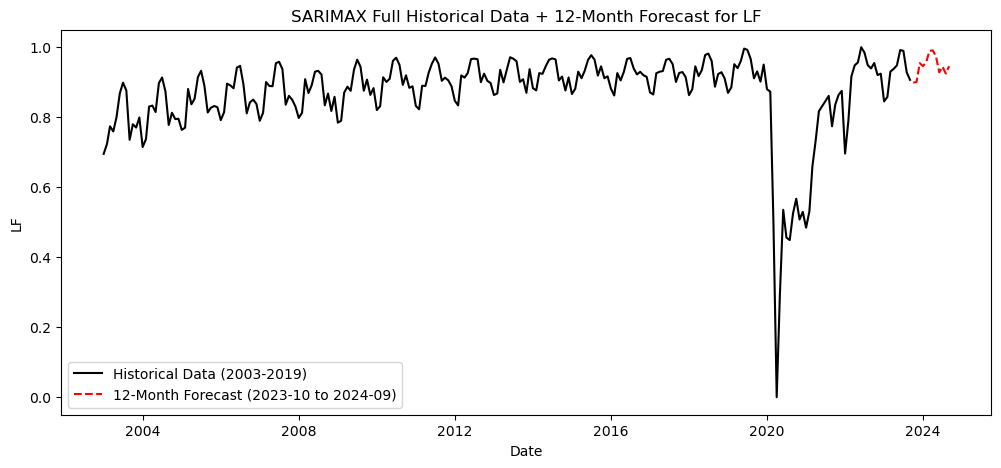

In [561]:
# Plot full historical data and forecast
plt.figure(figsize=(12, 5))

# Plot historical LF data
plt.plot(new_merged_data.index, new_merged_data["lf"], label="Historical Data (2003-2019)", color="black")

# Plot SARIMAX forecast for LF
plt.plot(forecast_df_sarimax.index, forecast_df_sarimax["lf"], label="12-Month Forecast (2023-10 to 2024-09)", color="red", linestyle="dashed")

# Add legend and title
plt.legend()
plt.title("SARIMAX Full Historical Data + 12-Month Forecast for LF")
plt.xlabel("Date")
plt.ylabel("LF")

# Show plot
plt.show()

## Forecasts Denormalization and Inverse-transformation

In [57]:
## xxxx
import numpy as np
import pandas as pd

# Manually storing SARIMA forecast values
sarima_pax = np.array([1.001207, 0.983906, 0.995804, 0.966180, 0.951237, 1.015288, 
                        1.002350, 1.017651, 1.028431, 1.039097, 1.027599, 0.983081])

sarima_rpm = np.array([0.977109, 0.955643, 0.976424, 0.950966, 0.927426, 0.990903, 
                        0.979574, 0.996974, 1.013716, 1.025610, 1.013738, 0.965471])

# Manually storing SARIMAX forecast values
sarimax_lf = np.array([0.898737, 0.900813, 0.954558, 0.945906, 0.958782, 0.989383, 
                        0.991081, 0.973744, 0.928172, 0.944334, 0.924814, 0.945933])

# Storing corresponding dates
forecast_dates = pd.date_range(start="2023-10-01", periods=12, freq='MS')

# Creating DataFrame for SARIMA forecasts (Pax and RPM)
forecasts_df_sarima = pd.DataFrame({
    "date": forecast_dates,
    "pax": sarima_pax,
    "rpm": sarima_rpm
})

# Creating DataFrame for SARIMAX forecasts (LF)
forecast_df_sarimax = pd.DataFrame({
    "date": forecast_dates,
    "lf": sarimax_lf
})

# Display the DataFrames
print("SARIMA Forecasts:\n", forecasts_df_sarima)
print("\nSARIMAX Forecasts:\n", forecast_df_sarimax)

SARIMA Forecasts:
          date       pax       rpm
0  2023-10-01  1.001207  0.977109
1  2023-11-01  0.983906  0.955643
2  2023-12-01  0.995804  0.976424
3  2024-01-01  0.966180  0.950966
4  2024-02-01  0.951237  0.927426
5  2024-03-01  1.015288  0.990903
6  2024-04-01  1.002350  0.979574
7  2024-05-01  1.017651  0.996974
8  2024-06-01  1.028431  1.013716
9  2024-07-01  1.039097  1.025610
10 2024-08-01  1.027599  1.013738
11 2024-09-01  0.983081  0.965471

SARIMAX Forecasts:
          date        lf
0  2023-10-01  0.898737
1  2023-11-01  0.900813
2  2023-12-01  0.954558
3  2024-01-01  0.945906
4  2024-02-01  0.958782
5  2024-03-01  0.989383
6  2024-04-01  0.991081
7  2024-05-01  0.973744
8  2024-06-01  0.928172
9  2024-07-01  0.944334
10 2024-08-01  0.924814
11 2024-09-01  0.945933


In [58]:
forecasts_df_sarima

date       pax       rpm
0  2023-10-01  1.001207  0.977109
1  2023-11-01  0.983906  0.955643
2  2023-12-01  0.995804  0.976424
3  2024-01-01  0.966180  0.950966
4  2024-02-01  0.951237  0.927426
5  2024-03-01  1.015288  0.990903
6  2024-04-01  1.002350  0.979574
7  2024-05-01  1.017651  0.996974
8  2024-06-01  1.028431  1.013716
9  2024-07-01  1.039097  1.025610
10 2024-08-01  1.027599  1.013738
11 2024-09-01  0.983081  0.965471

In [59]:
forecast_df_sarimax

date        lf
0  2023-10-01  0.898737
1  2023-11-01  0.900813
2  2023-12-01  0.954558
3  2024-01-01  0.945906
4  2024-02-01  0.958782
5  2024-03-01  0.989383
6  2024-04-01  0.991081
7  2024-05-01  0.973744
8  2024-06-01  0.928172
9  2024-07-01  0.944334
10 2024-08-01  0.924814
11 2024-09-01  0.945933

In [60]:
new_merged_data = pd.read_csv("new_merged_data.csv")

In [61]:
new_merged_data

date   dom_pax   int_pax       pax   dom_flt   int_flt       flt  \
0    2003-01-01  0.828347  0.793857  0.820499  0.910438  0.871604  0.908376   
1    2003-02-01  0.814774  0.761803  0.804444  0.819246  0.829628  0.821181   
2    2003-03-01  0.874255  0.798454  0.861259  0.921217  0.879301  0.919042   
3    2003-04-01  0.855569  0.766968  0.841053  0.893171  0.854763  0.890714   
4    2003-05-01  0.869064  0.780110  0.854507  0.914252  0.856443  0.909859   
..          ...       ...       ...       ...       ...       ...       ...   
242  2023-05-01  0.983498  0.959543  0.978907  0.795213  0.950331  0.819013   
243  2023-06-01  0.988005  0.983570  0.986938  0.788772  0.966578  0.816535   
244  2023-07-01  1.000000  1.000000  1.000000  0.813669  0.987084  0.842057   
245  2023-08-01  0.983731  0.984100  0.983470  0.820406  0.975267  0.845561   
246  2023-09-01  0.963273  0.937849  0.958141  0.775812  0.910075  0.794892   

      dom_rpm   int_rpm       rpm   dom_asm   int_asm       asm    dom_lf  \
0    0.793350  0.801216  0.790920  0.736973  0.784158  0.733187  0.668011   
1    0.775808  0.760013  0.765686  0.656956  0.738777  0.662510  0.716664   
2    0.836089  0.795618  0.819319  0.754120  0.780307  0.742419  0.773254   
3    0.819088  0.752706  0.795101  0.717485  0.737563  0.701000  0.769351   
4    0.830506  0.777249  0.810081  0.726473  0.739635  0.707688  0.793417   
..        ...       ...       ...       ...       ...       ...       ...   
242  0.976218  0.964832  0.971324  0.963621  0.967933  0.961351  0.945492   
243  0.985246  0.989113  0.986245  0.965737  0.982200  0.970276  0.976194   
244  1.000000  1.000000  1.000000  0.999903  1.000000  1.000000  0.976454   
245  0.981503  0.989524  0.983965  1.000000  0.996205  0.997983  0.907506   
246  0.953096  0.958672  0.953747  0.944829  0.960666  0.946362  0.890725   

       int_lf        lf  fuel_spot_price  transformed_price  \
0    0.732539  0.695392            0.887          -0.118830   
1    0.687736  0.723410            1.055           0.053758   
2    0.718660  0.774001            0.893          -0.112206   
3    0.658169  0.759395            0.743          -0.290487   
4    0.767989  0.799894            0.714          -0.328437   
..        ...       ...              ...                ...   
242  0.916428  0.947948            2.173           0.823482   
243  1.000000  0.991767            2.250           0.862743   
244  0.990647  0.989510            2.488           0.977277   
245  0.944486  0.928031            2.989           1.190794   
246  0.910243  0.906785            3.120           1.241575   

     monthly_nomial_gdp  monthly_real_gdp  
0          11135.823560      14595.873344  
1          11210.374001      14652.422580  
2          11176.189440      14595.658491  
3          11256.955779      14673.487907  
4          11275.223148      14690.107595  
..                  ...               ...  
242        27462.538988      22570.944497  
243        27575.422194      22613.014338  
244        27741.003055      22693.154686  
245        28024.431289      22826.789237  
246        28137.656657      22827.792163  

[247 rows x 20 columns]

In [62]:
new_merged_data["date"] = pd.to_datetime(new_merged_data["date"])

# Combine historical data with SARIMA forecast (Pax & RPM)
all_sarima = pd.concat([new_merged_data[["date", "pax", "rpm"]], forecasts_df_sarima], axis=0)

# Combine historical data with SARIMAX forecast (LF)
all_sarimax = pd.concat([new_merged_data[["date", "lf"]], forecast_df_sarimax], axis=0)

# Display the combined dataframes
print("All SARIMA Data (Historical + Forecast):")
display(all_sarima)

print("\nAll SARIMAX Data (Historical + Forecast):")
display(all_sarimax)

All SARIMA Data (Historical + Forecast):


date       pax       rpm
0  2003-01-01  0.820499  0.790920
1  2003-02-01  0.804444  0.765686
2  2003-03-01  0.861259  0.819319
3  2003-04-01  0.841053  0.795101
4  2003-05-01  0.854507  0.810081
..        ...       ...       ...
7  2024-05-01  1.017651  0.996974
8  2024-06-01  1.028431  1.013716
9  2024-07-01  1.039097  1.025610
10 2024-08-01  1.027599  1.013738
11 2024-09-01  0.983081  0.965471

[259 rows x 3 columns]


All SARIMAX Data (Historical + Forecast):


date        lf
0  2003-01-01  0.695392
1  2003-02-01  0.723410
2  2003-03-01  0.774001
3  2003-04-01  0.759395
4  2003-05-01  0.799894
..        ...       ...
7  2024-05-01  0.973744
8  2024-06-01  0.928172
9  2024-07-01  0.944334
10 2024-08-01  0.924814
11 2024-09-01  0.945933

[259 rows x 2 columns]

In [63]:
air_traffic = pd.read_csv("air traffic.csv")

In [64]:
# Convert Year and Month into a datetime column
air_traffic['date'] = pd.to_datetime(air_traffic['Year'].astype(str) + '-' + air_traffic['Month'].astype(str) + '-01')

# Drop the original Year and Month columns
air_traffic.drop(columns=['Year', 'Month'], inplace=True)

print(air_traffic.info())
print(air_traffic.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Dom_Pax  249 non-null    object        
 1   Int_Pax  249 non-null    object        
 2   Pax      249 non-null    object        
 3   Dom_Flt  249 non-null    object        
 4   Int_Flt  249 non-null    object        
 5   Flt      249 non-null    object        
 6   Dom_RPM  249 non-null    object        
 7   Int_RPM  249 non-null    object        
 8   RPM      249 non-null    object        
 9   Dom_ASM  249 non-null    object        
 10  Int_ASM  249 non-null    object        
 11  ASM      249 non-null    object        
 12  Dom_LF   249 non-null    float64       
 13  Int_LF   249 non-null    float64       
 14  LF       249 non-null    float64       
 15  date     249 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(12)
memory usage: 31.3+ KB
None
      D

In [65]:
# Change Object variables to numerical variables

def clean_numeric_column(column):
    return pd.to_numeric(column.astype(str).str.replace(',', ''), errors='coerce')

object_columns = air_traffic.select_dtypes(include=['object']).columns

for col in object_columns:
    air_traffic[col] = clean_numeric_column(air_traffic[col])

air_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Dom_Pax  249 non-null    int64         
 1   Int_Pax  249 non-null    int64         
 2   Pax      249 non-null    int64         
 3   Dom_Flt  249 non-null    int64         
 4   Int_Flt  249 non-null    int64         
 5   Flt      249 non-null    int64         
 6   Dom_RPM  249 non-null    int64         
 7   Int_RPM  249 non-null    int64         
 8   RPM      249 non-null    int64         
 9   Dom_ASM  249 non-null    int64         
 10  Int_ASM  249 non-null    int64         
 11  ASM      249 non-null    int64         
 12  Dom_LF   249 non-null    float64       
 13  Int_LF   249 non-null    float64       
 14  LF       249 non-null    float64       
 15  date     249 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(12)
memory usage: 31.3 KB


In [66]:
air_traffic.describe()

Dom_Pax       Int_Pax           Pax        Dom_Flt       Int_Flt  \
count  2.490000e+02  2.490000e+02  2.490000e+02     249.000000    249.000000   
mean   5.520971e+07  7.392209e+06  6.260192e+07  706750.710843  64736.172691   
min    2.877290e+06  1.366090e+05  3.013899e+06  217262.000000   4996.000000   
25%    5.098217e+07  6.395022e+06  5.766458e+07  662000.000000  61615.000000   
50%    5.620010e+07  7.419187e+06  6.389913e+07  709933.000000  66557.000000   
75%    6.089213e+07  8.567847e+06  6.944743e+07  781804.000000  71924.000000   
max    7.537816e+07  1.243262e+07  8.781077e+07  890938.000000  82681.000000   
std    1.044055e+07  2.020273e+06  1.229211e+07  107054.971522  12129.622461   

                 Flt       Dom_RPM       Int_RPM           RPM       Dom_ASM  \
count     249.000000  2.490000e+02  2.490000e+02  2.490000e+02  2.490000e+02   
mean   771486.883534  4.957803e+07  1.918103e+07  6.875906e+07  6.131822e+07   
min    222280.000000  2.551127e+06  3.567620e+05  2.907889e+06  1.948908e+07   
25%    727898.000000  4.458029e+07  1.660284e+07  6.182568e+07  5.655552e+07   
50%    779011.000000  4.985794e+07  1.968901e+07  6.900519e+07  6.088909e+07   
75%    848650.000000  5.568257e+07  2.266760e+07  7.803987e+07  6.626877e+07   
max    964102.000000  7.226790e+07  3.137600e+07  1.036439e+08  8.199740e+07   
std    115686.728629  1.035558e+07  5.711621e+06  1.548875e+07  8.996673e+06   

            Int_ASM           ASM      Dom_LF      Int_LF          LF  \
count  2.490000e+02  2.490000e+02  249.000000  249.000000  249.000000   
mean   2.413903e+07  8.545724e+07   79.938394   77.304940   79.286305   
min    1.541419e+06  2.103050e+07   13.090000   23.150000   13.830000   
25%    2.173119e+07  7.919780e+07   77.720000   76.430000   76.940000   
50%    2.464572e+07  8.505191e+07   82.120000   79.910000   81.580000   
75%    2.770535e+07  9.255187e+07   85.240000   82.930000   84.070000   
max    3.532619e+07  1.173122e+08   89.960000   89.440000   89.140000   
std    5.650437e+06  1.382385e+07    8.860562   10.907145    8.895700   

                                date  
count                            249  
mean   2013-05-01 15:54:13.012048128  
min              2003-01-01 00:00:00  
25%              2008-03-01 00:00:00  
50%              2013-05-01 00:00:00  
75%              2018-07-01 00:00:00  
max              2023-09-01 00:00:00  
std                              NaN

In [67]:
# Convert all column names to lowercase for consistency
air_traffic.columns = air_traffic.columns.str.lower()
all_sarima.columns = all_sarima.columns.str.lower()
all_sarimax.columns = all_sarimax.columns.str.lower()

# Print column names to verify
print("Updated column names in air_traffic:", air_traffic.columns)
print("Updated column names in all_sarima:", all_sarima.columns)
print("Updated column names in all_sarimax:", all_sarimax.columns)

Updated column names in air_traffic: Index(['dom_pax', 'int_pax', 'pax', 'dom_flt', 'int_flt', 'flt', 'dom_rpm',
       'int_rpm', 'rpm', 'dom_asm', 'int_asm', 'asm', 'dom_lf', 'int_lf', 'lf',
       'date'],
      dtype='object')
Updated column names in all_sarima: Index(['date', 'pax', 'rpm'], dtype='object')
Updated column names in all_sarimax: Index(['date', 'lf'], dtype='object')


In [68]:
# Extract original min/max values from air_traffic
original_min = air_traffic[["pax", "rpm", "lf"]].min()
original_max = air_traffic[["pax", "rpm", "lf"]].max()

# Function to apply manual MinMax inverse transformation
def minmax_inverse_transform(data, col):
    return data * (original_max[col] - original_min[col]) + original_min[col]

# Undo log transformation for Pax & RPM
all_sarima[["pax", "rpm"]] = np.expm1(all_sarima[["pax", "rpm"]])

# 1️⃣ Inverse transform SARIMA (Pax & RPM)
all_sarima[["pax", "rpm"]] = all_sarima[["pax", "rpm"]].apply(lambda x: minmax_inverse_transform(x, x.name))

# 2️⃣ Inverse transform SARIMAX (LF)
all_sarimax[["lf"]] = all_sarimax[["lf"]].apply(lambda x: minmax_inverse_transform(x, x.name))

# Display results
print("Transformed Back - SARIMA Data:")
display(all_sarima)

print("\nTransformed Back - SARIMAX Data:")
display(all_sarimax)

Transformed Back - SARIMA Data:


date           pax           rpm
0  2003-01-01  1.108443e+08  1.243375e+08
1  2003-02-01  1.077765e+08  1.188017e+08
2  2003-03-01  1.188581e+08  1.307372e+08
3  2003-04-01  1.148447e+08  1.252685e+08
4  2003-05-01  1.175079e+08  1.286354e+08
..        ...           ...           ...
7  2024-05-01  1.528235e+08  1.751734e+08
8  2024-06-01  1.553663e+08  1.797825e+08
9  2024-07-01  1.579092e+08  1.831041e+08
10 2024-08-01  1.551690e+08  1.797886e+08
11 2024-09-01  1.448518e+08  1.667071e+08

[259 rows x 3 columns]


Transformed Back - SARIMAX Data:


date         lf
0  2003-01-01  66.200000
1  2003-02-01  68.310000
2  2003-03-01  72.120000
3  2003-04-01  71.020000
4  2003-05-01  74.070000
..        ...        ...
7  2024-05-01  87.162661
8  2024-06-01  83.730633
9  2024-07-01  84.947794
10 2024-08-01  83.477742
11 2024-09-01  85.068214

[259 rows x 2 columns]

In [69]:
all_sarima

date           pax           rpm
0  2003-01-01  1.108443e+08  1.243375e+08
1  2003-02-01  1.077765e+08  1.188017e+08
2  2003-03-01  1.188581e+08  1.307372e+08
3  2003-04-01  1.148447e+08  1.252685e+08
4  2003-05-01  1.175079e+08  1.286354e+08
..        ...           ...           ...
7  2024-05-01  1.528235e+08  1.751734e+08
8  2024-06-01  1.553663e+08  1.797825e+08
9  2024-07-01  1.579092e+08  1.831041e+08
10 2024-08-01  1.551690e+08  1.797886e+08
11 2024-09-01  1.448518e+08  1.667071e+08

[259 rows x 3 columns]

In [70]:
# Ensure 'date' column is in datetime format
all_sarima["date"] = pd.to_datetime(all_sarima["date"])
air_traffic["date"] = pd.to_datetime(air_traffic["date"])

# Define fixed minimum values and corresponding date
fixed_min_values = {"pax": 3013899.0, "rpm": 2907889.0}
fixed_min_date = "2020-04-01"  # Ensure values remain unchanged on this date

# Identify reference date (first available date) for calculating differences
reference_date = all_sarima["date"].iloc[0] 

# Compute differences with air_traffic at the reference date
difference_pax = all_sarima.loc[all_sarima["date"] == reference_date, "pax"].values[0] - \
                 air_traffic.loc[air_traffic["date"] == reference_date, "pax"].values[0]

difference_rpm = all_sarima.loc[all_sarima["date"] == reference_date, "rpm"].values[0] - \
                 air_traffic.loc[air_traffic["date"] == reference_date, "rpm"].values[0]

# Function to adjust values while keeping the fixed minimum value unchanged at '2020-04-01'
def adjust_values(df, column, difference, min_value, min_date):
    df[column] = df.apply(lambda row: row[column] - difference 
                          if row["date"].strftime('%Y-%m-%d') != min_date else min_value, axis=1)
    return df

# Apply adjustments while ensuring '2020-04-01' remains unchanged
all_sarima = adjust_values(all_sarima, "pax", difference_pax, fixed_min_values["pax"], fixed_min_date)
all_sarima = adjust_values(all_sarima, "rpm", difference_rpm, fixed_min_values["rpm"], fixed_min_date)

# Display adjusted DataFrame
print("\n Adjusted SARIMA Data (Ensuring '2020-04-01' Remains Unchanged):")
display(all_sarima)


 Adjusted SARIMA Data (Ensuring '2020-04-01' Remains Unchanged):


date           pax           rpm
0  2003-01-01  4.793828e+07  4.909740e+07
1  2003-02-01  4.487045e+07  4.356154e+07
2  2003-03-01  5.595210e+07  5.549711e+07
3  2003-04-01  5.193865e+07  5.002835e+07
4  2003-05-01  5.460189e+07  5.339533e+07
..        ...           ...           ...
7  2024-05-01  8.991749e+07  9.993329e+07
8  2024-06-01  9.246023e+07  1.045424e+08
9  2024-07-01  9.500320e+07  1.078640e+08
10 2024-08-01  9.226300e+07  1.045485e+08
11 2024-09-01  8.194573e+07  9.146698e+07

[259 rows x 3 columns]

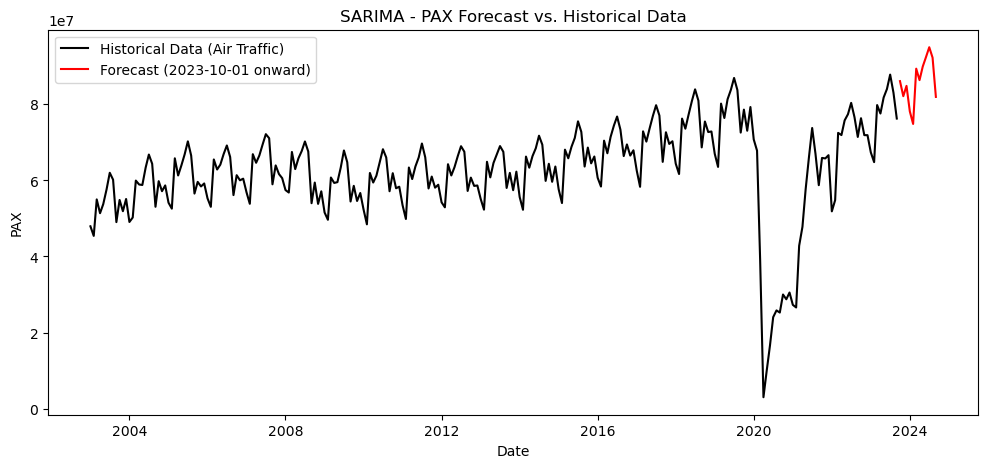

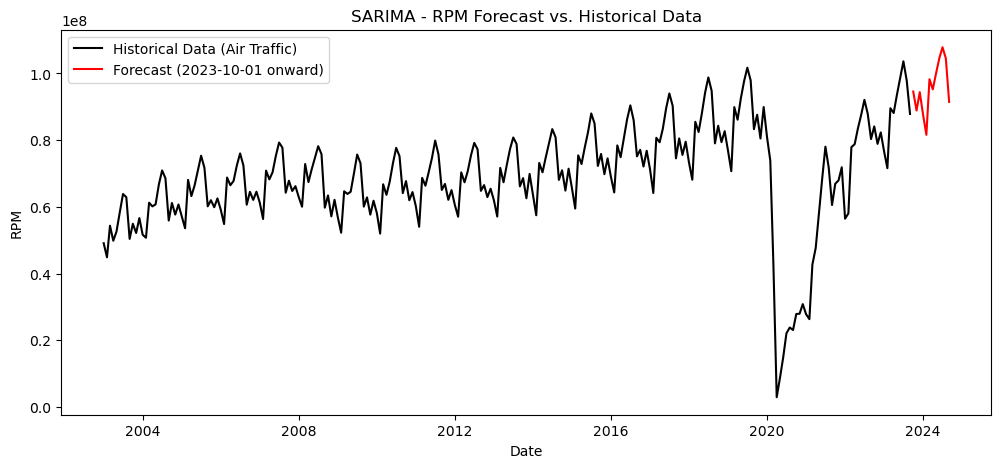

In [87]:
import matplotlib.pyplot as plt

# Ensure 'date' column is in datetime format
all_sarima["date"] = pd.to_datetime(all_sarima["date"])
forecast_start = pd.to_datetime("2023-10-01")  # Convert forecast start date to datetime

# Plot PAX
plt.figure(figsize=(12, 5))
plt.plot(all_sarima["date"], all_sarima["pax"], color="black", label="Historical Data")
plt.plot(all_sarima.loc[all_sarima["date"] >= forecast_start, "date"], 
         all_sarima.loc[all_sarima["date"] >= forecast_start, "pax"], 
         color="red", label="Forecast (2023-10-01 onward)")
plt.title("SARIMA - PAX Forecast vs. Historical Data")
plt.xlabel("Date")
plt.ylabel("PAX")
plt.legend()
plt.show()

# Plot RPM
plt.figure(figsize=(12, 5))
plt.plot(all_sarima["date"], all_sarima["rpm"], color="black", label="Historical Data")
plt.plot(all_sarima.loc[all_sarima["date"] >= forecast_start, "date"], 
         all_sarima.loc[all_sarima["date"] >= forecast_start, "rpm"], 
         color="red", label="Forecast (2023-10-01 onward)")
plt.title("SARIMA - RPM Forecast vs. Historical Data")
plt.xlabel("Date")
plt.ylabel("RPM")
plt.legend()
plt.show()

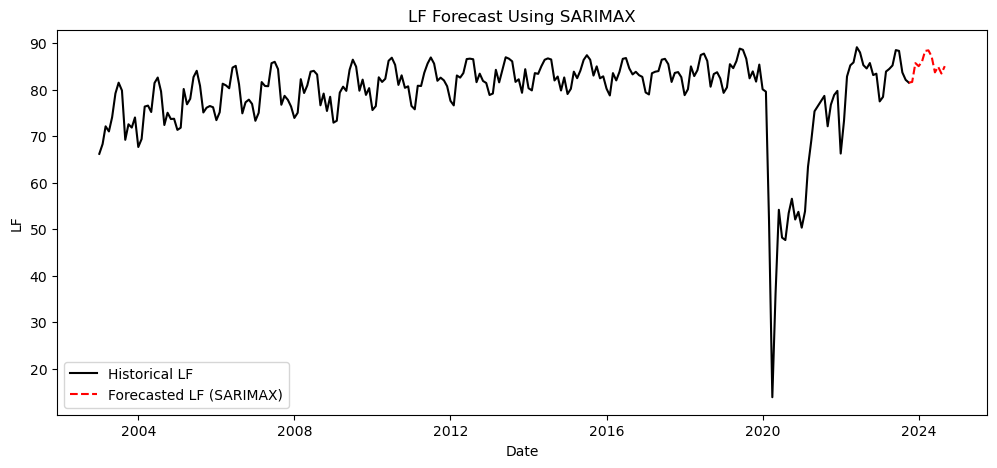

In [606]:
# Define forecast start date
forecast_start = "2023-10-01"

# Split historical and forecasted data
historical_data = all_sarimax.loc[:forecast_start]
forecast_data = all_sarimax.loc[forecast_start:]

# Plot historical data in black
plt.figure(figsize=(12, 5))
plt.plot(historical_data.index, historical_data["lf"], label="Historical LF", color="black")

# Plot forecasted data in red
plt.plot(forecast_data.index, forecast_data["lf"], label="Forecasted LF (SARIMAX)", color="red", linestyle="dashed")

# Add title, labels, and legend
plt.title("LF Forecast Using SARIMAX")
plt.xlabel("Date")
plt.ylabel("LF")
plt.legend()

# Show plot
plt.show()
